In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
    
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from jupyterthemes import jtplot
jtplot.style(theme='chesterish')
%matplotlib inline

In [2]:
sales = pd.read_csv('game_sales.csv')

In [3]:
sales.shape

(16719, 16)

In [4]:
sales.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# I have to do something with the null values in these columns.
# Name: doesnt matter since we won't be using it in the final model. (Must use numeric data, or 
# categorical data that has undergone 'one-hot encoding' to turn it into a binary 0, 1).
# Year_of_Release: dropping values since there's only 200.
# Genre: Dropping rows with null since this is probably a good indicator of sales.
# Publisher: Dropping rows with null since this is probably a good indicator of sales.
# Critic/User Scores: Dropping rows with null since this is probably a primary indicator of sales. 
# Critic/User Count: There are so many null values that I am dropping these columns entirely. 
sales.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [6]:
sales = sales.dropna(subset=['Name', 'Year_of_Release', 'Publisher', 'Genre', 'Critic_Score', 'User_Score',
                            'Rating', 'Developer']).reset_index(drop=True)
sales = sales.drop(columns=['Critic_Count', 'User_Count']).reset_index(drop=True)
sales['Critic_Score'] = sales['Critic_Score'].apply(float)
sales = sales[sales['User_Score'] != 'tbd'].reset_index(drop=True)
sales['User_Score'] = sales['User_Score'].apply(float)

In [7]:
sales.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'User_Score', 'Developer', 'Rating'],
      dtype='object')

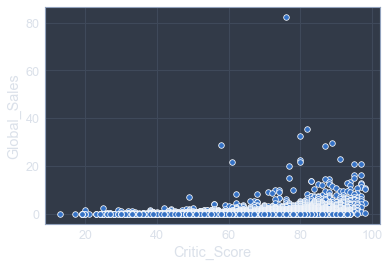

In [8]:
sns.scatterplot(x='Critic_Score', y='Global_Sales', data=sales);

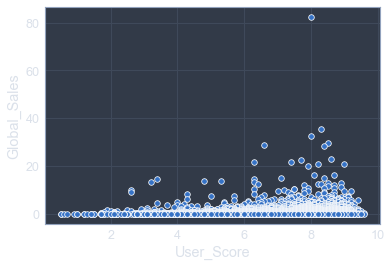

In [9]:
sns.scatterplot(x='User_Score', y='Global_Sales', data=sales);

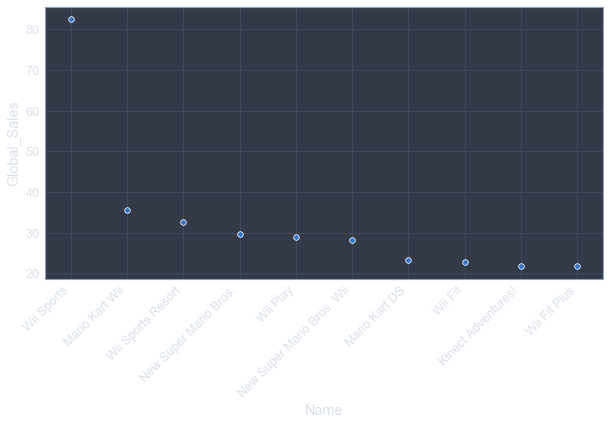

In [10]:
subset = sales.sort_values(by='Global_Sales', ascending=False).iloc[0:10]
plt.figure(figsize=(10,5))
sns.scatterplot(x='Name', y='Global_Sales', data=subset)
plt.xticks(rotation=45, horizontalalignment='right');

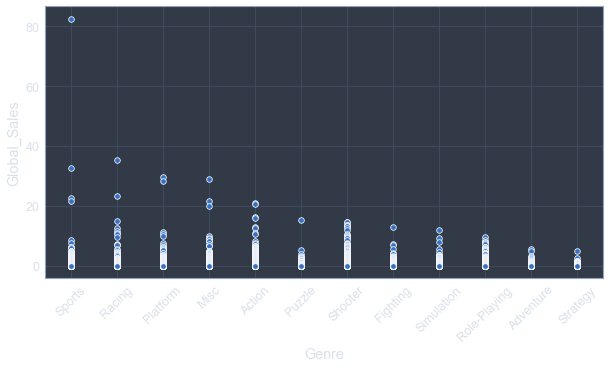

In [11]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Genre', y='Global_Sales', data=sales)
plt.xticks(rotation=45);

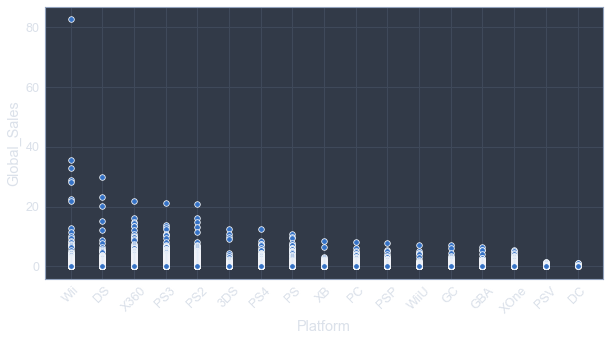

In [12]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Platform', y='Global_Sales', data=sales)
plt.xticks(rotation=45);

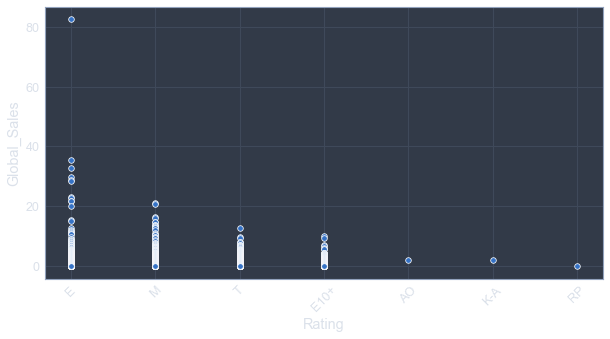

In [13]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Rating', y='Global_Sales', data=sales)
plt.xticks(rotation=45);

In [14]:
# Choosing target and features 
features = sales[['Platform', 'Genre', 'Critic_Score', 'User_Score', 'Rating', 'Name']]
target = sales['Global_Sales']

In [15]:
# Since the model can only use numeric data, setting the index as the game's name to retain the
# labels for plotting later. 
features = features.set_index('Name')

In [16]:
# One-hot encoding features that are categorical in nature.
features = pd.get_dummies(features, columns=['Platform','Genre', 'Rating'], drop_first=True)
features.columns

Index(['Critic_Score', 'User_Score', 'Platform_DC', 'Platform_DS',
       'Platform_GBA', 'Platform_GC', 'Platform_PC', 'Platform_PS',
       'Platform_PS2', 'Platform_PS3', 'Platform_PS4', 'Platform_PSP',
       'Platform_PSV', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XB', 'Platform_XOne', 'Genre_Adventure', 'Genre_Fighting',
       'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation',
       'Genre_Sports', 'Genre_Strategy', 'Rating_E', 'Rating_E10+',
       'Rating_K-A', 'Rating_M', 'Rating_RP', 'Rating_T'],
      dtype='object')

In [17]:
# performing grid search to tune dem hyperparameters
# max_depth refers to the maximum depth of the tree.
# n_estimators, the number of trees in the forest. 
# Ideally, you can expect a better performance from your model when there are more trees. 
# However, you must be cautious of the value ranges you specify and experiment using different 
# values to see how your model performs.

forest = RandomForestRegressor()
gsc = GridSearchCV(estimator=forest,
                   param_grid={
                       'max_depth':range(3,7),
                       'n_estimators': (10, 50, 100, 1000),
                   },
                   cv=5, scoring='neg_mean_squared_error', verbose=1,
                   n_jobs=-1)
grid_result = gsc.fit(features, target)
best_params = grid_result.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   24.2s finished


In [18]:
# Pass the best possible hyper parameters to the model.
forest = RandomForestRegressor(**best_params)

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           random_state=42,
                                                                           test_size=.25)


# We scale features when working with numerical data of differing magnitudes.
# Example: Age of a user and their blood pressure. 
# Turns the data into number of standard deviations from the mean giving a common scale. 
# We only fit the training data to prevent test data from leaking into the model.
# we transform both testing and training features. 

sc = StandardScaler()
features_train_sc = sc.fit_transform(features_train)
features_test_sc = sc.transform(features_test)

forest.fit(features_train_sc, target_train)

predictions = forest.predict(features_test_sc)

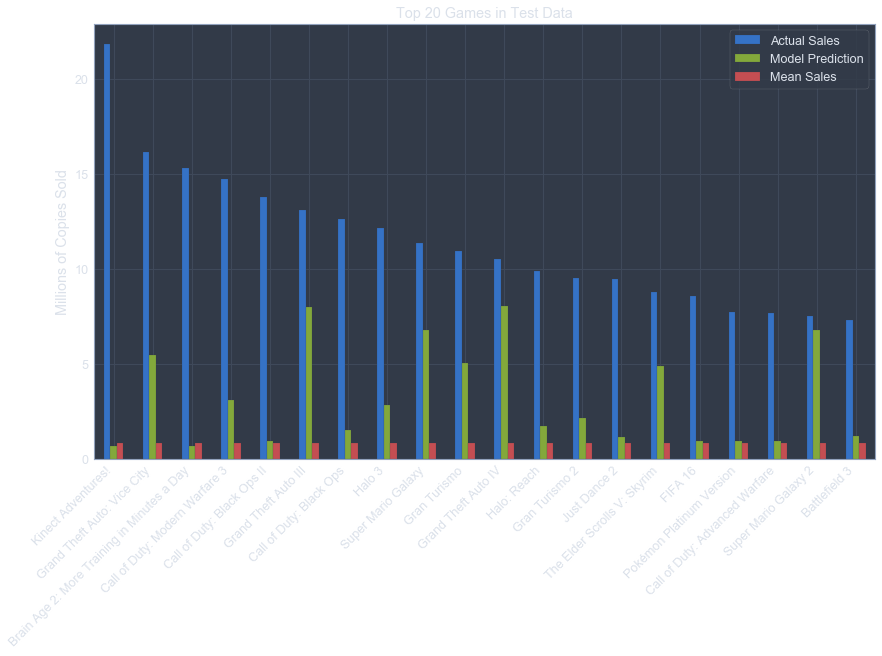

In [19]:
to_plot = pd.DataFrame()
to_plot['Actual Sales'] = target_test
to_plot['Model Prediction'] = predictions
to_plot['Mean Sales'] = to_plot['Actual Sales'].mean()
to_plot['Name'] = features_test.index
to_plot = to_plot.sort_values('Actual Sales', ascending=False).reset_index(drop=True)

ax = to_plot.iloc[0:20].plot(kind='bar', title='Top 20 Games in Test Data', figsize=(14,8))
ax.set_xticklabels(to_plot['Name'], rotation=45, horizontalalignment='right')
ax.set_ylabel('Millions of Copies Sold');

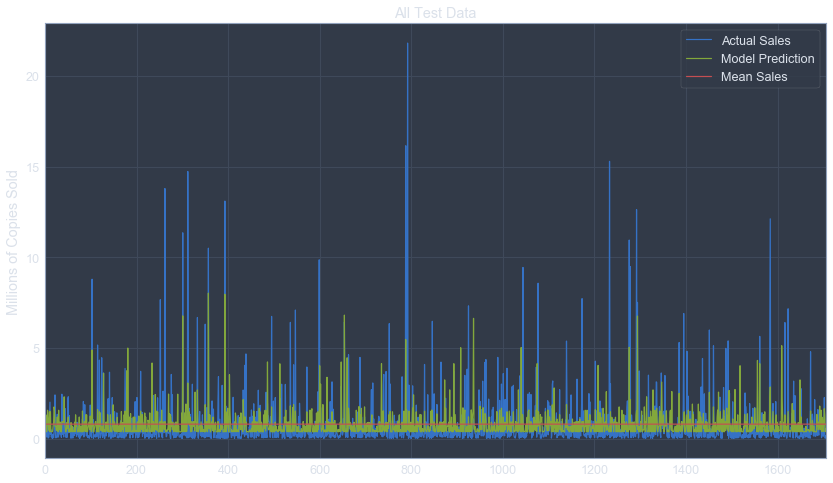

In [20]:
to_plot = pd.DataFrame()
to_plot['Actual Sales'] = target_test
to_plot['Model Prediction'] = predictions
to_plot['Mean Sales'] = to_plot['Actual Sales'].mean()
to_plot['Name'] = features_test.index
to_plot = to_plot.reset_index(drop=True)

ax = to_plot.plot(title='All Test Data', figsize=(14,8))
ax.set_ylabel('Millions of Copies Sold');

In [21]:
# Scores for regression problems primarily use these three metrics.

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions), 'million')
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions), 'million')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions)), 'million')

Mean Absolute Error: 0.703518491719771 million
Mean Squared Error: 1.994836455685706 million
Root Mean Squared Error: 1.4123867939363162 million


Error: The distance between the predicted and measured sales.<br>
Mean Absolute Error: Average error for the entire test sample. This measure is useful but prone to being overly influenced by outliers.<br>
Mean Squared Error: Less prone to being influenced by outliers, but larger than the actual error because it is squared.<br>
Root Mean Squared Error: Preferred metric since it is the root of the square. Less influenced by outliers, and of an understandable magnitude.<br>
Overall Performance: RMSE is ~1.4 million... But does this mean the model is "good"?<br>
One way to measure model "goodness" is to compare how much better the model prediction is to the mean prediction. If we're generally better than the mean guess, then we can say our model is providing some benefit. The better we are than the mean, the greater the benefit. 

In [22]:
baseline_rmse = np.sqrt(metrics.mean_squared_error(target_test, to_plot['Mean Sales'])) 
prediction_rmse = np.sqrt(metrics.mean_squared_error(target_test, predictions))

print(baseline_rmse - prediction_rmse)

0.1745554919140473


## Findings:
Overall, the model prediction is better than the average guess by only ~174k sales which is NOT great when you consider that sales on are the scale of millions. Looking at the top selling and worst selling games, our model does not do a great job at prediction, but looking at all the data shows that we do a better job than the mean guess. I might be able to improve performance by address narrowing scope: Can we predict first person shooter sales in North America?

In [23]:
sales.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,8.0,Nintendo,E
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,8.3,Nintendo,E
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,8.0,Nintendo,E
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,8.5,Nintendo,E
4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,6.6,Nintendo,E


In [24]:
shooters = sales[sales['Genre'] == 'Shooter'].reset_index(drop=True)
shooters

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Developer,Rating
0,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,Activision,9.04,4.24,0.13,1.32,14.73,88.0,3.4,"Infinity Ward, Sledgehammer Games",M
1,Call of Duty: Black Ops,X360,2010.0,Shooter,Activision,9.70,3.68,0.11,1.13,14.61,87.0,6.3,Treyarch,M
2,Call of Duty: Black Ops II,PS3,2012.0,Shooter,Activision,4.99,5.73,0.65,2.42,13.79,83.0,5.3,Treyarch,M
3,Call of Duty: Black Ops II,X360,2012.0,Shooter,Activision,8.25,4.24,0.07,1.12,13.67,83.0,4.8,Treyarch,M
4,Call of Duty: Modern Warfare 2,X360,2009.0,Shooter,Activision,8.52,3.59,0.08,1.28,13.47,94.0,6.3,Infinity Ward,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,The Chronicles of Riddick: Assault on Dark Athena,PC,2009.0,Shooter,Vivendi Games,0.00,0.01,0.00,0.00,0.01,80.0,8.0,Starbreeze,M
860,Conflict: Denied Ops,PC,2008.0,Shooter,Eidos Interactive,0.00,0.01,0.00,0.00,0.01,58.0,4.8,Pivotal Games,M
861,Greg Hastings' Tournament Paintball Max'd,PS2,2006.0,Shooter,Activision,0.01,0.00,0.00,0.00,0.01,70.0,9.2,Activision Value,E10+
862,Clive Barker's Jericho,PC,2007.0,Shooter,Codemasters,0.00,0.01,0.00,0.00,0.01,63.0,7.5,"Mercury Steam, Alchemic Productions",M


In [25]:
# Choosing target and features 
features = shooters[['Platform', 'Critic_Score', 'User_Score', 'Rating', 'Name']]
features = pd.get_dummies(features, columns=['Platform', 'Rating'], drop_first=True)
features = features.set_index('Name')
target = shooters['NA_Sales']

In [26]:
forest = RandomForestRegressor()
gsc = GridSearchCV(estimator=forest, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1,
                   param_grid={
                       'max_depth':range(3,7),
                       'n_estimators': (10, 50, 100, 1000),
                   })
grid_result = gsc.fit(features, target)
best_params = grid_result.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  57 out of  80 | elapsed:    2.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.7s finished


In [27]:
forest = RandomForestRegressor(**best_params)

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           random_state=42,
                                                                           test_size=.30)

sc = StandardScaler()
features_train_sc = sc.fit_transform(features_train)
features_test_sc = sc.transform(features_test)

forest.fit(features_train_sc, target_train)

predictions = forest.predict(features_test_sc)

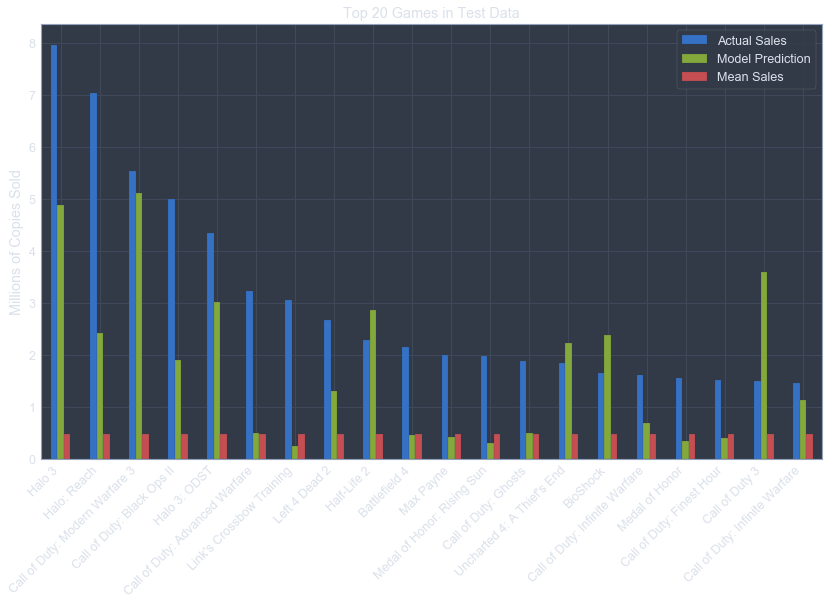

In [31]:
to_plot = pd.DataFrame()
to_plot['Actual Sales'] = target_test
to_plot['Model Prediction'] = predictions
to_plot['Mean Sales'] = to_plot['Actual Sales'].mean()
to_plot['Name'] = features_test.index
to_plot = to_plot.sort_values('Actual Sales', ascending=False).reset_index(drop=True)

ax = to_plot.iloc[0:20].plot(kind='bar', figsize=(14,8), title='Top 20 Games in Test Data')
ax.set_xticklabels(to_plot['Name'], rotation=45, horizontalalignment='right')
ax.set_ylabel('Millions of Copies Sold');

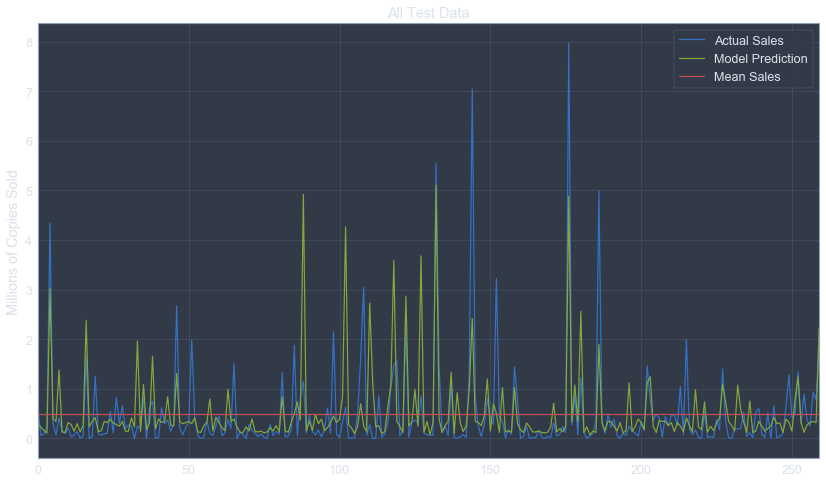

In [32]:
to_plot = pd.DataFrame()
to_plot['Actual Sales'] = target_test
to_plot['Model Prediction'] = predictions
to_plot['Mean Sales'] = to_plot['Actual Sales'].mean()
to_plot['Name'] = features_test.index
to_plot = to_plot.reset_index(drop=True)

ax = to_plot.plot(title='All Test Data', figsize=(14,8))
ax.set_ylabel('Millions of Copies Sold');

In [29]:
# Scores for regression problems primarily use these three metrics.

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions), 'million')
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions), 'million')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions)), 'million')

Mean Absolute Error: 0.3902297053716132 million
Mean Squared Error: 0.5682019027630748 million
Root Mean Squared Error: 0.7537916839306963 million


In [30]:
baseline_rmse = np.sqrt(metrics.mean_squared_error(target_test, to_plot['Mean Sales'])) 
prediction_rmse = np.sqrt(metrics.mean_squared_error(target_test, predictions))

print(baseline_rmse - prediction_rmse)

0.19759033479896737


## Findings: 
We did slightly better by narrowing the scope. Better than the average guess by ~197k sales, however, the model is still not performing terribly well.